In [ ]:
# Standard library
import gc
import glob
import json
import re
import shutil
import time
import importlib
from collections import Counter
from datetime import datetime, timezone
from pathlib import Path

# Third-party

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
)
import gdown

import pyarrow as pa
import pyarrow.parquet as pq


# Project imports

import utils.text_functions as tf
from utils.store_data import store_raw_articles_parquet

importlib.reload(tf)

/Users/brianramesh/Documents/MAT_project/Modality-aware-transformer/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils.text_functions' from '/Users/brianramesh/Documents/MAT_project/Modality-aware-transformer/utils/text_functions.py'>

Toutes les sections avec (*) nécessitent temps longs de run, à éviter les tables sont fournies. Pour manipuler les tables finales et voir le contenu aller à la section Data Check directement.

## Raw data (*)

Data from the [FNSPID dataset](https://huggingface.co/datasets/Zihan1004/FNSPID). (Raw data)


In [ ]:
# visualisation test (pas besoin de run)

ds = load_dataset("Zihan1004/FNSPID", streaming=True) # true pour pas tout télécharger en local
#print(ds) 

split_name = list(ds.keys())[0]
it = iter(ds[split_name])

samples = [next(it) for _ in range(3)]
#print("Keys:", samples[0].keys())
#print("Example:", samples[0])

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
# récupère la base en brut en séparé pour faire du prétraitement par la suite

ds = load_dataset("Zihan1004/FNSPID", streaming=True)
split = ds["train"]

# Étapes universelles, sans hypothèse de causalité
split_raw = (
    split
    .map(tf.make_projector())       # garde colonnes utiles
    .map(tf.build_text_record)      # parse dt_utc + clean strings
    .filter(tf.is_valid_record)     # garde lignes minimales valides (dt_utc, stock_symbol, au moins un texte)
)

total = store_raw_articles_parquet(
    iterable=split_raw,
    out_dir="data/fnspid_raw",
    chunk_size=500_000,
    desc="Storing FNSPID raw"
)

print(f"Total rows written: {total}")

Repo card metadata block was not found. Setting CardData to empty.
Storing FNSPID raw: 8957329rows [2:51:27, 870.69rows/s]  


Total rows written: 8957329


In [ ]:
raw_dir = Path("data/fnspid_raw")
f = raw_dir / "raw_00002.parquet"   

df = pd.read_parquet(f)
df.head()

,dt_utc,stock_symbol,url,publisher,author,title,article,textrank_summary,lexrank_summary,lsa_summary,luhn_summary
0,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/markets/company-news/...,Monica Gerson,None,US Stocks Open Higher On Earnings Beat,None,None,None,None,None
1,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff 5,None,"Jefferies & Company, Inc. Maintains Hold Ratin...",None,None,None,None,None
2,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/markets/company-news/...,Daniel Hayden IV,None,Parker-Hannifin (PH) Profit Nearly Triples,None,None,None,None,None
3,2010-01-20 00:00:00+00:00,PH,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff 5,None,Parker-Hannifin (PH) Optimally Priced,None,None,None,None,None
4,2010-01-19 00:00:00+00:00,PH,https://www.benzinga.com/trading-ideas/long-id...,Monica Gerson,None,Parker Hannifin Gives The Market A Pleasant Su...,None,None,None,None,None


In [ ]:
# voir le max/min des dates parmi la base de données

files = sorted(raw_dir.glob("raw_*.parquet"))

results = []

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    min_dt = df["dt_utc"].min()
    max_dt = df["dt_utc"].max()

    results.append({
        "file": f.name,
        "min_dt": min_dt,
        "max_dt": max_dt,
        "rows": len(df)
    })

    print(f.name, "min:", min_dt, "max:", max_dt, "rows:", len(df))

raw_00000.parquet min: 2009-04-29 00:00:00+00:00 max: 2020-06-11 05:54:38+00:00 rows: 500000
raw_00001.parquet min: 2009-02-14 00:00:00+00:00 max: 2020-06-11 13:11:20+00:00 rows: 500000
raw_00002.parquet min: 2009-04-27 00:00:00+00:00 max: 2020-06-11 13:12:35+00:00 rows: 500000
raw_00003.parquet min: 2010-02-03 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00004.parquet min: 1969-12-31 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00005.parquet min: 2010-02-03 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00006.parquet min: 2009-04-08 00:00:00+00:00 max: 2024-01-09 00:00:00+00:00 rows: 500000
raw_00007.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:56:00+00:00 rows: 500000
raw_00008.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:54:00+00:00 rows: 500000
raw_00009.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:56:00+00:00 rows: 500000
raw_00010.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:54

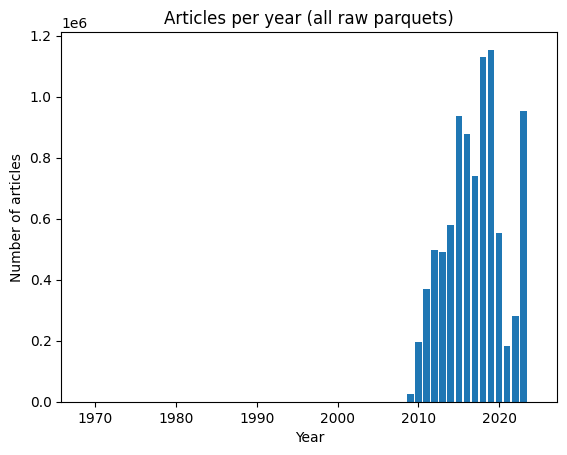

In [ ]:
year_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    year_counter.update(dt.dt.year.dropna().astype(int))

years = sorted(year_counter)
counts = [year_counter[y] for y in years]

plt.figure()
plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Articles per year (all raw parquets)")
plt.show()

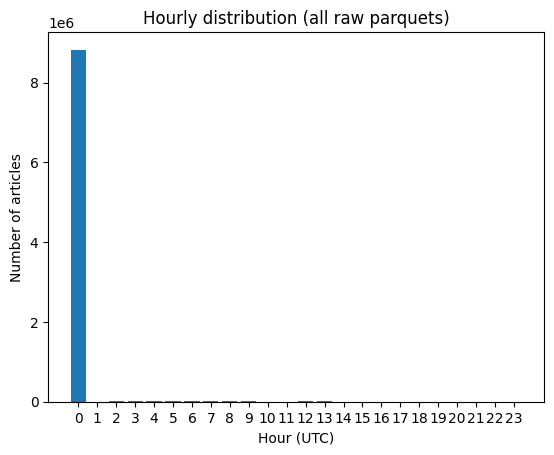

In [ ]:
hour_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    hour_counter.update(dt.dt.hour.dropna().astype(int))

hours = list(range(24))
counts = [hour_counter.get(h, 0) for h in hours]

plt.figure()
plt.bar(hours, counts)
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of articles")
plt.title("Hourly distribution (all raw parquets)")
plt.xticks(range(0, 24))
plt.show()

In [ ]:
# regarde quand est ce que l'article est dispo

results = []

for f in files:
    # On lit uniquement la colonne 'article'
    df = pd.read_parquet(f, columns=["article"])

    n_total = len(df)
    n_not_none = df["article"].notna().sum()
    n_none = n_total - n_not_none

    results.append({
        "parquet": f.name,
        "total": n_total,
        "article_not_none": n_not_none,
        "article_none": n_none,
        "share_not_none": n_not_none / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| article != None:", n_not_none,
        "| article == None:", n_none,
        "| share:", round(n_not_none / n_total, 4)
    )

raw_00000.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00001.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00002.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00003.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00004.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00005.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00006.parquet | total: 500000 | article != None: 267227 | article == None: 232773 | share: 0.5345
raw_00007.parquet | total: 500000 | article != None: 500000 | article == None: 0 | share: 1.0
raw_00008.parquet | total: 500000 | article != None: 500000 | article == None: 0 | share: 1.0
raw_00009.parquet | total: 500000 | article != None: 499998 | article == None: 2 | share: 1.0
raw_00010.parquet | total: 500000 | article != None:

In [ ]:
# regarde quand est ce que le titre est dispo 

results = []

for f in files:
    # On lit uniquement la colonne 'article'
    df = pd.read_parquet(f, columns=["title"])

    n_total = len(df)
    n_not_none = df["title"].notna().sum()
    n_none = n_total - n_not_none

    results.append({
        "parquet": f.name,
        "total": n_total,
        "title_not_none": n_not_none,
        "title_none": n_none,
        "share_not_none": n_not_none / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| title_summary != None:", n_not_none,
        "| title_summary == None:", n_none,
        "| share:", round(n_not_none / n_total, 4)
    )

raw_00000.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00001.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00002.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00003.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00004.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00005.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00006.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00007.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00008.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00009.parquet | total: 500000 | title_summ

In [ ]:
# regarde quand est-ce que l'article est dispo (heure != 00)

results = []

for f in files:
    # On lit uniquement la colonne dt_utc
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    n_total = len(dt)

    # heures valides
    hours = dt.dt.hour

    n_not_midnight = (hours != 0).sum()
    n_midnight = (hours == 0).sum()

    results.append({
        "parquet": f.name,
        "total": n_total,
        "hour_not_00": int(n_not_midnight),
        "hour_00": int(n_midnight),
        "share_not_00": n_not_midnight / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| hour != 00:", int(n_not_midnight),
        "| hour == 00:", int(n_midnight),
        "| share:", round(n_not_midnight / n_total, 4)
    )

raw_00000.parquet | total: 500000 | hour != 00: 18861 | hour == 00: 481139 | share: 0.0377
raw_00001.parquet | total: 500000 | hour != 00: 19379 | hour == 00: 480621 | share: 0.0388
raw_00002.parquet | total: 500000 | hour != 00: 16249 | hour == 00: 483751 | share: 0.0325
raw_00003.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00004.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00005.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00006.parquet | total: 500000 | hour != 00: 3565 | hour == 00: 496435 | share: 0.0071
raw_00007.parquet | total: 500000 | hour != 00: 6345 | hour == 00: 493655 | share: 0.0127
raw_00008.parquet | total: 500000 | hour != 00: 5055 | hour == 00: 494945 | share: 0.0101
raw_00009.parquet | total: 500000 | hour != 00: 7086 | hour == 00: 492914 | share: 0.0142
raw_00010.parquet | total: 500000 | hour != 00: 3050 | hour == 00: 496950 | share: 0.0061
raw_00011.parquet | total

## Processing data (*)

In [ ]:
# Dossiers

in_dir = Path("data/fnspid_raw")
out_dir = Path("data/fnspid_processed")
out_dir.mkdir(parents=True, exist_ok=True)

raw_files = sorted(in_dir.glob("raw_*.parquet"))

print(f"Found {len(raw_files)} raw parquet files")


# Traitement

for i, f in enumerate(tqdm(raw_files, desc="Processing raw -> processed", unit="file")):
    df = pd.read_parquet(f)

    # dt_utc -> datetime UTC
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    # effective_date = prochain jour de trading NYSE
    df["effective_date"] = df["dt_utc"].dt.date.apply(
        lambda d: tf.next_trading_day_nyse(d).isoformat()
        if pd.notna(d) else None
    )

    # Texte final : headline uniquement
    df["text"] = df["title"]
    df["text_source"] = "title"
    df["text_len"] = df["text"].fillna("").str.split().str.len()

    # Filtres finaux
    df = df[
        df["effective_date"].notna()
        & df["stock_symbol"].notna()
        & df["text"].notna()
        & (df["text_len"] >= 3)
    ].copy()

    # Dédoublonnage (URL > fallback hash) (on enlève les doubles url si pas dispo (titre, time, entreprise) similaireq)
    df["dedup_key"] = df.apply(tf.make_dedup_key, axis=1)
    df = (
        df
        .drop_duplicates(subset=["dedup_key"], keep="first")
        .drop(columns=["dedup_key"])
    )

    # Colonnes finales
    df = df[
        [
            "effective_date",
            "stock_symbol",
            "dt_utc",
            "text",
            "text_source",
            "text_len",
            "publisher",
            "url",
        ]
    ]

    # Écriture
    df.to_parquet(
        out_dir / f"processed_{i:05d}.parquet",
        index=False
    )

print("Processing completed successfully")

Found 0 raw parquet files


Processing raw -> processed: 0file [00:00, ?file/s]

Processing completed successfully


In [ ]:
process_dir = Path("data/fnspid_processed")
f = process_dir / "processed_00002.parquet"   

df = pd.read_parquet(f)
display(df.head())

files = sorted(process_dir.glob("processed_*.parquet"))
print(f"{len(files)} parquet files found")

,effective_date,stock_symbol,dt_utc,text,text_source,text_len,publisher,url
0,2010-04-21,PH,2010-04-20 00:00:00+00:00,US Stocks Open Higher On Earnings Beat,title,7,Monica Gerson,https://www.benzinga.com/markets/company-news/...
1,2010-04-21,PH,2010-04-20 00:00:00+00:00,"Jefferies & Company, Inc. Maintains Hold Ratin...",title,11,Benzinga Staff 5,https://www.benzinga.com/analyst-ratings/analy...
2,2010-04-21,PH,2010-04-20 00:00:00+00:00,Parker-Hannifin (PH) Profit Nearly Triples,title,5,Daniel Hayden IV,https://www.benzinga.com/markets/company-news/...
3,2010-01-21,PH,2010-01-20 00:00:00+00:00,Parker-Hannifin (PH) Optimally Priced,title,4,Benzinga Staff 5,https://www.benzinga.com/analyst-ratings/analy...
4,2010-01-20,PH,2010-01-19 00:00:00+00:00,Parker Hannifin Gives The Market A Pleasant Su...,title,8,Monica Gerson,https://www.benzinga.com/trading-ideas/long-id...


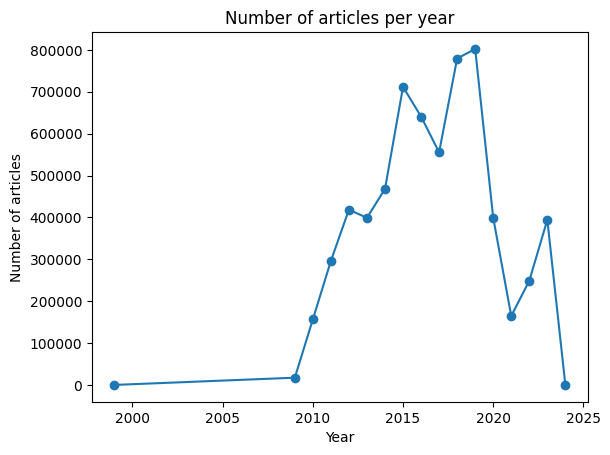

In [12]:
year_counts = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["effective_date"])
    years = pd.to_datetime(df["effective_date"], errors="coerce").dt.year
    year_counts.update(years.dropna().astype(int))

years = sorted(year_counts)
counts = [year_counts[y] for y in years]

plt.figure()
plt.plot(years, counts, marker="o")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of articles per year")
plt.show()

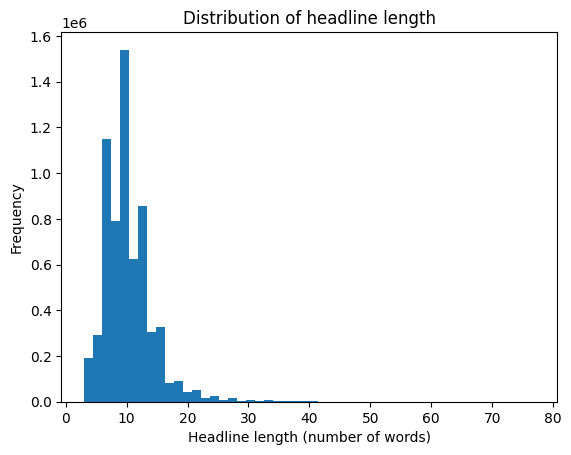

In [40]:
lengths = []

for f in files:
    df = pd.read_parquet(f, columns=["text_len"])
    lengths.extend(df["text_len"].dropna().tolist())

plt.figure()
plt.hist(lengths, bins=50)
plt.xlabel("Headline length (number of words)")
plt.ylabel("Frequency")
plt.title("Distribution of headline length")
plt.show()

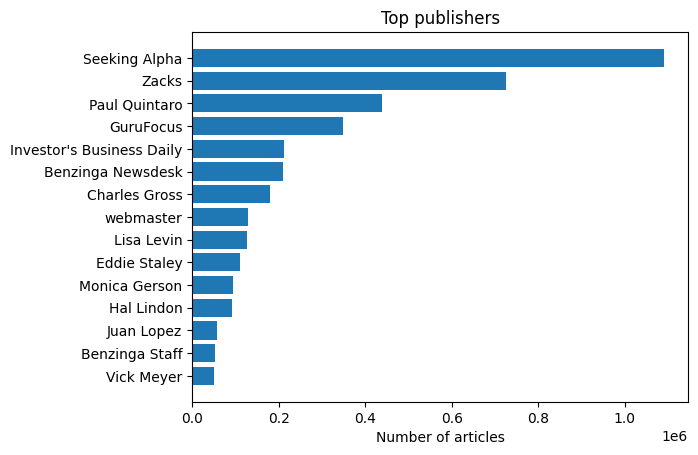

In [42]:
publisher_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["publisher"])
    publisher_counter.update(df["publisher"].dropna())

top = publisher_counter.most_common(15)
labels, values = zip(*top)

plt.figure()
plt.barh(labels[::-1], values[::-1])
plt.xlabel("Number of articles")
plt.title("Top publishers")
plt.show()

In [10]:
total = 0
for f in files:
    n = len(pd.read_parquet(f, columns=["text"]))
    total += n
    print(f"{f.name:20s} | rows: {n}")

print("-" * 40)
print("Total rows:", total)

processed_00000.parquet | rows: 363826
processed_00001.parquet | rows: 368680
processed_00002.parquet | rows: 388161
processed_00003.parquet | rows: 347239
processed_00004.parquet | rows: 351252
processed_00005.parquet | rows: 350761
processed_00006.parquet | rows: 382221
processed_00007.parquet | rows: 347529
processed_00008.parquet | rows: 303483
processed_00009.parquet | rows: 353391
processed_00010.parquet | rows: 374280
processed_00011.parquet | rows: 391568
processed_00012.parquet | rows: 363658
processed_00013.parquet | rows: 370710
processed_00014.parquet | rows: 383198
processed_00015.parquet | rows: 341612
processed_00016.parquet | rows: 350216
processed_00017.parquet | rows: 319343
----------------------------------------
Total rows: 6451128


## Features (*)

### Sentiment analysis (FinBERT Model)

In [ ]:
# Paramètres

data_dir = Path("data/fnspid_processed")
out_dir = Path("data/fnspid_sentiment")
out_dir.mkdir(parents=True, exist_ok=True)

batch_size = 512          # nombre de passage par le modèle
device = "cuda" if torch.cuda.is_available() else "cpu" # à modifier avec Apple

In [24]:
# Modèle FinBERT

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name) #tokenizer associé au modèle
model = AutoModelForSequenceClassification.from_pretrained(model_name) # charger reseau de neurone FinBert
model.to(device)
model.eval() #pas de train juste prediction

label_map = {0: "negative", 1: "neutral", 2: "positive"}

In [25]:
# Boucle sur les parquets

files = sorted(data_dir.glob("processed_*.parquet"))

for i, f in enumerate(tqdm(files, desc="FinBERT sentiment", unit="file")):
    df = pd.read_parquet(f, columns=[
        "effective_date", "stock_symbol", "dt_utc",
        "text", "publisher", "url"
    ]) 

    texts = df["text"].astype(str).tolist()

    pos_scores, neg_scores, neu_scores, sent_scores = [], [], [], []

    print(f'We are on :', device)

    # Batch inference
    for j in range(0, len(texts), batch_size):
        batch_texts = texts[j:j + batch_size] # parcourt toute la base selon le batch size
        
        enc = tokenizer(
            batch_texts,
            padding=True, # remplissage quand token petit
            truncation=True, #coupure quand trop grand
            max_length=64,   # headlines courts
            return_tensors="pt"
        ).to(device)

        with torch.no_grad(): #on entraine pas (pas de calcul de gradient)
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()

        # ordre FinBERT: [neg, neu, pos]
        neg = probs[:, 0]
        neu = probs[:, 1]
        pos = probs[:, 2]

        neg_scores.extend(neg)
        neu_scores.extend(neu)
        pos_scores.extend(pos)
        sent_scores.extend(pos - neg) # choix particulier naif parce que donne une direction mais peut être changé

    # Ajout des colonnes sentiment
    df["sent_neg"] = neg_scores
    df["sent_neu"] = neu_scores
    df["sent_pos"] = pos_scores
    df["sent_score"] = sent_scores

    # Écriture
    df.to_parquet(
        out_dir / f"sentiment_{i:05d}.parquet",
        index=False
    )

print("FinBERT sentiment extraction completed")

FinBERT sentiment:   0%|          | 0/18 [00:00<?, ?file/s]

We are on : cuda


FinBERT sentiment:   6%|▌         | 1/18 [19:24<5:29:59, 1164.69s/file]

We are on : cuda


FinBERT sentiment:  11%|█         | 2/18 [38:56<5:11:46, 1169.14s/file]

We are on : cuda


FinBERT sentiment:  17%|█▋        | 3/18 [57:52<4:48:26, 1153.75s/file]

We are on : cuda


FinBERT sentiment:  22%|██▏       | 4/18 [1:09:18<3:46:07, 969.13s/file]

We are on : cuda


FinBERT sentiment:  28%|██▊       | 5/18 [1:20:51<3:08:26, 869.69s/file]

We are on : cuda


FinBERT sentiment:  33%|███▎      | 6/18 [1:32:37<2:42:45, 813.82s/file]

We are on : cuda


FinBERT sentiment:  39%|███▉      | 7/18 [1:47:03<2:32:20, 830.92s/file]

We are on : cuda


FinBERT sentiment:  44%|████▍     | 8/18 [2:01:29<2:20:21, 842.13s/file]

We are on : cuda


FinBERT sentiment:  50%|█████     | 9/18 [2:14:05<2:02:17, 815.29s/file]

We are on : cuda


FinBERT sentiment:  56%|█████▌    | 10/18 [2:28:50<1:51:32, 836.61s/file]

We are on : cuda


FinBERT sentiment:  61%|██████    | 11/18 [2:44:09<1:40:34, 862.04s/file]

We are on : cuda


FinBERT sentiment:  67%|██████▋   | 12/18 [3:03:03<1:34:27, 944.61s/file]

We are on : cuda


FinBERT sentiment:  72%|███████▏  | 13/18 [3:22:25<1:24:12, 1010.52s/file]

We are on : cuda


FinBERT sentiment:  78%|███████▊  | 14/18 [3:42:13<1:10:57, 1064.28s/file]

We are on : cuda


FinBERT sentiment:  83%|████████▎ | 15/18 [3:57:10<50:41, 1013.83s/file]  

We are on : cuda


FinBERT sentiment:  89%|████████▉ | 16/18 [4:08:29<30:26, 913.01s/file] 

We are on : cuda


FinBERT sentiment:  94%|█████████▍| 17/18 [4:20:14<14:10, 850.38s/file]

We are on : cuda


FinBERT sentiment: 100%|██████████| 18/18 [4:30:45<00:00, 902.51s/file]

FinBERT sentiment extraction completed


### Embedding (FinBERT)

In [2]:
# Dossiers

data_dir = Path("data/fnspid_processed")
out_dir = Path("data/fnspid_embeddings")
out_dir.mkdir(parents=True, exist_ok=True)

# Modèle
model_name = "ProsusAI/finbert"

# Config
batch_size = 512        # GPU: 128–512 / CPU: 16–64
max_len = 64            # headlines
pooling = "mean"        # "mean" (recommandé)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

In [3]:
#Chargement tokenizer + encodeur (pas la tête de classification)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
# vecteur d'une headline c'est la moyenne des vecteur de chaque token

def mean_pooling(last_hidden_state, attention_mask):
    """
    last_hidden_state: (B, L, 768)
    attention_mask:    (B, L)
    return:            (B, 768)
    """
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

In [5]:
@torch.no_grad()
def encode_texts(texts):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.autocast(device_type="cuda", dtype=dtype, enabled=(device == "cuda")):
        outputs = model(**enc)
        emb = mean_pooling(outputs.last_hidden_state, enc["attention_mask"])

    return emb.cpu().float().numpy()  # (B, 768)

In [12]:
# traite les fichiers par partie

files = sorted(data_dir.glob("processed_*.parquet"))
print("Total files:", len(files))

start_idx = 0   # ex: 3
end_idx   = 1   # ex: 6 -> traitera 3,4,5

for i in tqdm(range(start_idx, end_idx), desc="Embedding selected files", unit="file"):
    f = files[i]
    out_file = out_dir / f"embed_{i:05d}.parquet"

    if out_file.exists():
        print("Skip:", out_file.name)
        continue

    print(f"\nProcessing {i}: {f.name}")

    df = pd.read_parquet(
        f,
        columns=["effective_date", "stock_symbol", "dt_utc", "text", "publisher", "url"]
    )
    df["text"] = df["text"].astype(str).fillna("")
    texts = df["text"].tolist()

    embeddings = np.zeros((len(df), 768), dtype=np.float32)

    for start in tqdm(range(0, len(texts), batch_size), desc=f"Batches ({f.name})", unit="batch", leave=False):
        batch_texts = texts[start:start + batch_size]
        emb = encode_texts(batch_texts)
        embeddings[start:start + len(batch_texts)] = emb

    df["emb"] = list(embeddings.astype(np.float16))
    df.to_parquet(out_file, index=False)

    print("Saved:", out_file)

Total files: 1


Embedding selected files:   0%|          | 0/1 [00:00<?, ?file/s]


Processing 0: processed_00017.parquet


Embedding selected files: 100%|██████████| 1/1 [02:47<00:00, 167.80s/file]

Saved: data/fnspid_embeddings/embed_00000.parquet


## Final Dataset

### Enlever les doublons entre fichiers

In [ ]:
ids_path = Path("config/drive_ids.json")

with open(ids_path, "r") as f:
    drive_ids = json.load(f)

sent_ids = drive_ids["sentiment"]
emb_ids  = drive_ids["embedded"]

print("Sent files:", len(sent_ids))
print("Emb files :", len(emb_ids))

Sent files: 18
Emb files : 18


In [ ]:
data_dir = Path("data")

sent_dir = data_dir / "fnspid_sentiment"
emb_dir  = data_dir / "fnspid_embedding"

sent_dir.mkdir(parents=True, exist_ok=True)
emb_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# a executer si on a pas fait la partie Features 

def download_drive_files(ids, out_dir, prefix, sleep_sec=1.5):
    paths = []
    for i, fid in enumerate(ids):
        out = out_dir / f"{prefix}_{i:03d}.parquet"
        if out.exists():
            paths.append(out)
            continue

        url = f"https://drive.google.com/uc?id={fid}"
        gdown.download(url, str(out), quiet=False)
        paths.append(out)

        # pause pour éviter le throttling Drive
        time.sleep(sleep_sec)

    return paths

sent_files = download_drive_files(sent_ids, sent_dir, "sentiment", sleep_sec=1.5)
emb_files  = download_drive_files(emb_ids,  emb_dir,  "embed",  sleep_sec=1.5)

print("Downloaded sent files:", len(sent_files))
print("Downloaded emb files :", len(emb_files))

Downloaded emb files : 18


In [ ]:
# retire les doublons entre fichiers

out_sent = Path("data/fnspid_sentiment_dedup")
out_emb  = Path("data/fnspid_embedding_dedup")
out_sent.mkdir(parents=True, exist_ok=True)
out_emb.mkdir(parents=True, exist_ok=True)

sent_files = sorted(sent_dir.glob("*.parquet"))
emb_files  = sorted(emb_dir.glob("*.parquet"))

if len(sent_files) != len(emb_files):
    raise ValueError(f"Nombre de fichiers différent: sent={len(sent_files)} emb={len(emb_files)}")

# Charge + concat tous les SENT avec provenance 
sent_dfs = []
for file_id, f in enumerate(tqdm(sent_files, desc="Read SENT files", unit="file")):
    df = pd.read_parquet(f)
    df["_file_id"] = np.int32(file_id)
    df["_row_in_file"] = np.arange(len(df), dtype=np.int32)
    sent_dfs.append(df)

sent_all = pd.concat(sent_dfs, ignore_index=True)
del sent_dfs
gc.collect()

# Construit dedup_key (URL first, fallback hash) ---
if "url" not in sent_all.columns:
    raise ValueError("Il faut une colonne 'url' dans SENT pour dédup simple.")

url = (sent_all["url"].astype("string").str.strip().str.lower())
url = url.where(url.notna() & (url != ""), None)

fallback_cols = [c for c in ["title","text","dt_utc","publisher","stock_symbol","effective_date"] if c in sent_all.columns]
fb = sent_all[fallback_cols].astype("string").fillna("").agg("|".join, axis=1) if fallback_cols else sent_all.index.astype("string")
fb_hash = pd.util.hash_pandas_object(fb, index=False).astype("uint64")
fb_key = "NOURL|" + fb_hash.astype(str)

sent_all["_dedup_key"] = np.where(url.notna(), "URL|" + url.astype(str), fb_key)

# Dédup global (garde la 1ère occurrence) 
keep = ~pd.Series(sent_all["_dedup_key"]).duplicated(keep="first")
sent_keep = sent_all.loc[keep].copy()

# Construire, pour chaque fichier, les lignes à garder 
# dict: file_id -> array d'indices de lignes à garder (triés)
keep_map = {}
for fid, g in sent_keep.groupby("_file_id", sort=False):
    keep_map[int(fid)] = np.sort(g["_row_in_file"].to_numpy(np.int32))

# écrire les SENT dédoublonnés, fichier par fichier
for fid, rows in tqdm(keep_map.items(), desc="Write SENT dedup", unit="file"):
    orig = pd.read_parquet(sent_files[fid])
    orig_out = orig.iloc[rows].reset_index(drop=True)
    orig_out.to_parquet(out_sent / sent_files[fid].name, index=False, compression="zstd")

# Filtrer EMB avec les mêmes rows (sans recalcul) 
for fid, rows in tqdm(keep_map.items(), desc="Write EMB dedup", unit="file"):
    emb = pd.read_parquet(emb_files[fid])
    if len(emb) < (rows.max() + 1):
        raise ValueError(f"Embed {emb_files[fid].name} a moins de lignes que nécessaire (alignement cassé).")
    emb_out = emb.iloc[rows].reset_index(drop=True)
    emb_out.to_parquet(out_emb / emb_files[fid].name, index=False, compression="zstd")

print("Done.")
print("SENT out:", out_sent)
print("EMB  out:", out_emb)
print("Total kept rows:", int(keep.sum()), "/", len(sent_all))

Write EMB dedup: 100%|██████████| 12/12 [01:59<00:00,  9.94s/file]

Done.
SENT out: data/fnspid_sentiment_dedup
EMB  out: data/fnspid_embedding_dedup
Total kept rows: 2944824 / 6451128


In [ ]:
in_sent = Path("data/fnspid_sentiment_dedup")
in_emb  = Path("data/fnspid_embedding_dedup")

out_sent = Path("data/fnspid_sentiment_dedup_chrono")
out_emb = Path("data/fnspid_embedding_dedup_chrono")
out_sent.mkdir(parents=True, exist_ok=True)
out_emb.mkdir(parents=True, exist_ok=True)

sent_files = sorted(in_sent.glob("*.parquet"))
emb_files  = sorted(in_emb.glob("*.parquet"))
if len(sent_files) != len(emb_files):
    raise ValueError(f"Mismatch nb files: sent={len(sent_files)} emb={len(emb_files)}")

# --------- périodes ----------
BINS = [
    ("2009-01-01", "2012-12-31"),
    ("2013-01-01", "2014-12-31"),
    ("2015-01-01", "2016-12-31"),
    ("2017-01-01", "2018-12-31"),
    ("2019-01-01", "2020-12-31"),
    ("2021-01-01", "2024-12-31"),
]

# labels lisibles basés sur les années
BIN_LABELS = [
    f"{pd.Timestamp(s).year}-{pd.Timestamp(e).year}" for s, e in BINS
]

bin_starts = pd.to_datetime([b[0] for b in BINS]).date
bin_ends   = pd.to_datetime([b[1] for b in BINS]).date

def assign_bin(d):
    out = [-1] * len(d)
    for i, dd in enumerate(d):
        if dd is None or pd.isna(dd):
            continue
        for bi, (s, e) in enumerate(zip(bin_starts, bin_ends)):
            if s <= dd <= e:
                out[i] = bi
                break
    return pd.Series(out, index=range(len(d)), dtype="int32")

sent_writers = {}
emb_writers = {}
sent_schema = None
emb_schema = None

def get_writer(writers, schema, path: Path):
    if path not in writers:
        writers[path] = pq.ParquetWriter(str(path), schema, compression="zstd")
    return writers[path]

# détecter colonne date
probe_cols = pd.read_parquet(sent_files[0]).columns
date_col = "effective_date" if "effective_date" in probe_cols else ("dt_utc" if "dt_utc" in probe_cols else None)
if date_col is None:
    raise ValueError("Ni effective_date ni dt_utc dans tes fichiers dedup.")

for sf, ef in tqdm(list(zip(sent_files, emb_files)), desc="Repartition chrono", unit="pair"):
    sent = pd.read_parquet(sf)
    emb  = pd.read_parquet(ef)
    if len(sent) != len(emb):
        raise ValueError(f"Alignement cassé: {sf.name} ({len(sent)}) vs {ef.name} ({len(emb)})")

    d = pd.to_datetime(sent[date_col], errors="coerce", utc=(date_col=="dt_utc")).dt.date
    bins = assign_bin(d.to_list())

    for bi in range(len(BINS)):
        idx = (bins == bi).to_numpy()
        if not idx.any():
            continue

        s_part = sent.loc[idx].copy()

        # tri chronologique dans le bin
        if date_col == "dt_utc":
            order = pd.to_datetime(s_part["dt_utc"], errors="coerce", utc=True).argsort(kind="mergesort")
        else:
            order = pd.to_datetime(s_part["effective_date"], errors="coerce").argsort(kind="mergesort")

        s_part = s_part.iloc[order].reset_index(drop=True)
        e_part = emb.loc[idx].iloc[order].reset_index(drop=True)

        s_tbl = pa.Table.from_pandas(s_part, preserve_index=False)
        e_tbl = pa.Table.from_pandas(e_part, preserve_index=False)

        if sent_schema is None:
            sent_schema = s_tbl.schema
        if emb_schema is None:
            emb_schema = e_tbl.schema

        s_tbl = s_tbl.cast(sent_schema, safe=False)
        e_tbl = e_tbl.cast(emb_schema, safe=False)

        label = BIN_LABELS[bi]  # ex "2013-2014"
        s_path = out_sent / f"sent_{label}.parquet"
        e_path = out_emb  / f"emb_{label}.parquet"

        get_writer(sent_writers, sent_schema, s_path).write_table(s_tbl)
        get_writer(emb_writers,  emb_schema,  e_path).write_table(e_tbl)

        del s_part, e_part, s_tbl, e_tbl
        gc.collect()

    del sent, emb, d, bins
    gc.collect()

for w in sent_writers.values():
    w.close()
for w in emb_writers.values():
    w.close()

print("Done. Wrote bins:")
for label, (s, e) in zip(BIN_LABELS, BINS):
    print(f"sent_{label}.parquet / emb_{label}.parquet : {s} -> {e}")

Repartition chrono: 100%|██████████| 12/12 [01:51<00:00,  9.32s/pair]

Done. Wrote bins:
sent_2009-2012.parquet / emb_2009-2012.parquet : 2009-01-01 -> 2012-12-31
sent_2013-2014.parquet / emb_2013-2014.parquet : 2013-01-01 -> 2014-12-31
sent_2015-2016.parquet / emb_2015-2016.parquet : 2015-01-01 -> 2016-12-31
sent_2017-2018.parquet / emb_2017-2018.parquet : 2017-01-01 -> 2018-12-31
sent_2019-2020.parquet / emb_2019-2020.parquet : 2019-01-01 -> 2020-12-31
sent_2021-2024.parquet / emb_2021-2024.parquet : 2021-01-01 -> 2024-12-31


In [ ]:
# pour classer par ordre chrono 

sent_dir = Path("data/fnspid_sentiment_dedup_chrono")
emb_dir  = Path("data/fnspid_embedding_dedup_chrono")

sent_bins = sorted(sent_dir.glob("sent_*.parquet"))
if not sent_bins:
    raise FileNotFoundError(f"Aucun sent_*.parquet dans {sent_dir}")

for sf in tqdm(sent_bins, desc="Global sort bins", unit="bin"):
    tag = sf.stem.replace("sent_", "")          # ex: "2009-2012"
    ef = emb_dir / f"emb_{tag}.parquet"
    if not ef.exists():
        raise FileNotFoundError(f"Missing matching emb for {sf.name}: expected {ef.name}")

    # Lire bin complet
    sent = pd.read_parquet(sf)
    emb  = pd.read_parquet(ef)

    if len(sent) != len(emb):
        raise ValueError(f"Alignement cassé: {sf.name} ({len(sent)}) vs {ef.name} ({len(emb)})")

    # Choix colonne de tri (dt_utc prioritaire)
    if "dt_utc" in sent.columns:
        d = pd.to_datetime(sent["dt_utc"], errors="coerce", utc=True)
    elif "effective_date" in sent.columns:
        d = pd.to_datetime(sent["effective_date"], errors="coerce")
    else:
        raise ValueError(f"{sf.name}: ni dt_utc ni effective_date pour trier")

    # Ordre stable
    order = d.argsort(kind="mergesort")

    sent2 = sent.iloc[order].reset_index(drop=True)
    emb2  = emb.iloc[order].reset_index(drop=True)

    # Ecriture atomique (évite de casser si crash en plein write)
    tmp_sf = sf.with_suffix(".tmp.parquet")
    tmp_ef = ef.with_suffix(".tmp.parquet")

    sent2.to_parquet(tmp_sf, index=False, compression="zstd")
    emb2.to_parquet(tmp_ef, index=False, compression="zstd")

    tmp_sf.replace(sf)
    tmp_ef.replace(ef)

    # Nettoyage mémoire
    del sent, emb, sent2, emb2, d, order
    gc.collect()

print(" Done: all bins globally sorted (sent + emb).")

 43%|████▎     | 238M/554M [1:18:46<1:44:32, 50.4kB/s]
Global sort bins: 100%|██████████| 6/6 [01:27<00:00, 14.63s/bin]

✅ Done: all bins globally sorted (sent + emb).


In [ ]:
# a executer une fois qu'on est sur d'avoir eu les bons output avant (pour supprimer les dossiers pas nécessaires et libérer espace)
base = Path("data")

dir_to_delete = [
    base / "fnspid_embedding",
    base / "fnspid_embedding_dedup",
    base / "fnspid_sentiment",
    base / "fnspid_sentiment_dedup",
]

for d in dir_to_delete:
    if d.exists():
        shutil.rmtree(d)
        print(f"Deleted: {d}")
    else:
        print(f"Not found (skipped): {d}")

print("Cleanup done.")

In [ ]:
# creation finale tables 

# ---- config ----
sent_dir = Path("data/fnspid_sentiment_dedup_chrono")
emb_dir  = Path("data/fnspid_embedding_dedup_chrono")
out_dir  = Path("data/final_parts")
out_dir.mkdir(parents=True, exist_ok=True)

SENT_COLS = ["effective_date", "dt_utc", "stock_symbol", "sent_score", "sent_pos", "sent_neg"]
EMB_COLS  = ["emb"]

def read_cols_safe(path: Path, wanted_cols):
    # tente lecture “light” (meilleur cas)
    try:
        return pd.read_parquet(path, columns=wanted_cols)
    except Exception:
        # fallback si colonnes manquantes
        df = pd.read_parquet(path)
        use = [c for c in wanted_cols if c in df.columns]
        return df[use]

def build_final_table(news: pd.DataFrame) -> pd.DataFrame:
    news["effective_date"] = pd.to_datetime(news["effective_date"], errors="coerce")

    def agg_group(gdf: pd.DataFrame) -> pd.Series:
        s  = gdf["sent_score"].to_numpy(np.float32)
        sp = gdf["sent_pos"].to_numpy(np.float32)
        sn = gdf["sent_neg"].to_numpy(np.float32)

        n_news  = len(gdf)
        s_sum   = float(s.sum())
        abs_sum = float(np.abs(s).sum())
        sp_sum  = float(sp.sum())
        sn_sum  = float(sn.sum())

        out = None
        out_wabs = None
        out_pos = None
        out_neg = None

        for emb, si, spi, sni in zip(gdf["emb"], s, sp, sn):
            v = np.asarray(emb, np.float32)
            out = v if out is None else out + v

            wabs = abs(float(si))
            out_wabs = (v * wabs) if out_wabs is None else out_wabs + v * wabs
            out_pos  = (v * float(spi)) if out_pos  is None else out_pos  + v * float(spi)
            out_neg  = (v * float(sni)) if out_neg  is None else out_neg  + v * float(sni)

        if out is None:
            out = np.zeros(768, np.float32)
            out_wabs = np.zeros(768, np.float32)
            out_pos = np.zeros(768, np.float32)
            out_neg = np.zeros(768, np.float32)

        n_safe = max(n_news, 1)
        emb_mean = (out / float(n_safe)).astype(np.float32)
        emb_mean_wabs = (out_wabs / float(abs_sum)).astype(np.float32) if abs_sum > 1e-9 else emb_mean
        emb_mean_pos  = (out_pos  / float(sp_sum)).astype(np.float32)  if sp_sum  > 1e-9 else emb_mean
        emb_mean_neg  = (out_neg  / float(sn_sum)).astype(np.float32)  if sn_sum  > 1e-9 else emb_mean

        return pd.Series({
            "n_news": n_news,
            "sent_score_sum": s_sum,
            "sent_abs_sum": abs_sum,
            "sent_pos_sum": sp_sum,
            "sent_neg_sum": sn_sum,
            "sent_score_mean": s_sum / n_safe,
            "sent_abs_mean": abs_sum / n_safe,
            "emb_mean": emb_mean,
            "emb_mean_wabs": emb_mean_wabs,
            "emb_mean_pos": emb_mean_pos,
            "emb_mean_neg": emb_mean_neg,
        })

    return (
        news.groupby(["effective_date", "stock_symbol"], as_index=False)
            .apply(agg_group)
            .reset_index(drop=True)
            .sort_values(["effective_date", "stock_symbol"], kind="mergesort")
            .reset_index(drop=True)
    )

# ---- loop over bins ----
sent_files = sorted(sent_dir.glob("sent_*.parquet"))
if not sent_files:
    raise FileNotFoundError(f"Aucun sent_*.parquet dans {sent_dir}")

for sf in tqdm(sent_files, desc="Build FINAL (aligned, no-merge)", unit="bin"):
    tag = sf.stem.replace("sent_", "")
    ef = emb_dir / f"emb_{tag}.parquet"
    if not ef.exists():
        raise FileNotFoundError(f"Missing matching emb file for {sf.name}: expected {ef.name}")

    out_file = out_dir / f"final_{tag}.parquet"
    if out_file.exists():
        continue

    sent = read_cols_safe(sf, SENT_COLS)
    emb  = read_cols_safe(ef, EMB_COLS)

    if len(sent) != len(emb):
        raise ValueError(f"Alignement cassé: {sf.name} ({len(sent)}) vs {ef.name} ({len(emb)})")

    sent["emb"] = emb["emb"].to_numpy()
    news = sent

    if "effective_date" not in news.columns:
        if "dt_utc" not in news.columns:
            raise ValueError(f"{sf.name}: ni effective_date ni dt_utc")
        news["effective_date"] = pd.to_datetime(
            news["dt_utc"], utc=True, errors="coerce"
        ).dt.date.astype(str)

    final_part = build_final_table(news)
    final_part.to_parquet(out_file, index=False, compression="zstd")

    del sent, emb, news, final_part
    gc.collect()

print("Done. Final parts written to:", out_dir)

Build FINAL (aligned, no-merge):   0%|          | 0/6 [00:00<?, ?bin/s]/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_78294/770688082.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_group)
Build FINAL (aligned, no-merge):  17%|█▋        | 1/6 [00:39<03:19, 39.99s/bin]/var/folders/yw/_46mwd495f7cdxgzr0znl5jc0000gn/T/ipykernel_78294/770688082.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning

Done. Final parts written to: data/final_parts


In [ ]:
f = 'data/final_parts/final_2015-2016.parquet'
df = pd.read_parquet(f)

## Data check 

In [ ]:
cfg_path = Path("config/drive_ids.json")
out_dir  = Path("data/final_parts")
out_dir.mkdir(parents=True, exist_ok=True)

# lire le json
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

if "final" not in cfg:
    raise KeyError("La clé 'final' est absente de drive_ids.json")

final_ids = cfg["final"]

# ---- download ----
for period, file_id in final_ids.items():
    period = period.lower()  # sécurité
    out_file = out_dir / f"final_{period}.parquet"

    if out_file.exists():
        print(f"skip (exists): {out_file.name}")
        continue

    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"downloading final_{period}.parquet")

    gdown.download(
        url,
        str(out_file),
        quiet=False
    )

print("download completed.")

In [ ]:
final_dir = Path("data/final_parts")
files = sorted(final_dir.glob("final_*.parquet"))
if not files:
    raise FileNotFoundError("Aucun final_*.parquet trouvé dans data/final_parts")

rows = []
all_dates = []

for f in tqdm(files, desc="Scan final_parts", unit="file"):
    d = pd.read_parquet(f, columns=["effective_date"])
    d["effective_date"] = pd.to_datetime(d["effective_date"], errors="coerce")
    d = d.dropna().drop_duplicates().sort_values("effective_date").reset_index(drop=True)

    if len(d) == 0:
        rows.append({
            "file": f.name,
            "start": None,
            "end": None,
            "n_days_present": 0,
            "n_days_expected_D": 0,
            "n_missing_D": 0,
            "n_days_expected_B": 0,
            "n_missing_B": 0,
        })
        continue

    start = d["effective_date"].min()
    end   = d["effective_date"].max()

    full_D = pd.date_range(start, end, freq="D")
    full_B = pd.date_range(start, end, freq="B")

    missing_D = full_D.difference(d["effective_date"])
    missing_B = full_B.difference(d["effective_date"])

    rows.append({
        "file": f.name,
        "start": start.date(),
        "end": end.date(),
        "n_days_present": int(len(d)),
        "n_days_expected_D": int(len(full_D)),
        "n_missing_D": int(len(missing_D)),
        "n_days_expected_B": int(len(full_B)),
        "n_missing_B": int(len(missing_B)),
    })

    all_dates.append(d[["effective_date"]])

# résumé par fichier 
by_file = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
display(by_file)

# résumé global par année (tous les fichiers)
dates = pd.concat(all_dates, ignore_index=True).drop_duplicates()
dates["year"] = dates["effective_date"].dt.year

year_rows = []
for year, g in dates.groupby("year"):
    dmin = g["effective_date"].min()
    dmax = g["effective_date"].max()

    full_B = pd.date_range(dmin, dmax, freq="B")
    missing_B = full_B.difference(g["effective_date"])

    year_rows.append({
        "year": int(year),
        "start": dmin.date(),
        "end": dmax.date(),
        "n_days_present": int(g["effective_date"].nunique()),
        "n_business_days": int(len(full_B)),
        "n_missing_business_days": int(len(missing_B)),
        "coverage_B": float(g["effective_date"].nunique() / len(full_B)),
    })

by_year = pd.DataFrame(year_rows).sort_values("year").reset_index(drop=True)
display(by_year)

Scan final_parts: 100%|██████████| 6/6 [00:00<00:00, 53.76file/s]


,file,start,end,n_days_present,n_days_expected_D,n_missing_D,n_days_expected_B,n_missing_B
0,final_2009-2012.parquet,2009-02-17,2012-12-31,902,1414,512,1010,108
1,final_2013-2014.parquet,2013-01-02,2014-12-31,504,729,225,521,17
2,final_2015-2016.parquet,2015-01-02,2016-12-30,504,729,225,521,17
3,final_2017-2018.parquet,2017-01-03,2018-12-31,502,728,226,520,18
4,final_2019-2020.parquet,2019-01-02,2020-12-31,505,730,225,522,17
5,final_2021-2024.parquet,2021-01-04,2024-01-10,760,1102,342,788,28


,year,start,end,n_days_present,n_business_days,n_missing_business_days,coverage_B
0,2009,2009-02-17,2009-12-31,148,228,80,0.649123
1,2010,2010-01-04,2010-12-31,252,260,8,0.969231
2,2011,2011-01-03,2011-12-30,252,260,8,0.969231
3,2012,2012-01-03,2012-12-31,250,260,10,0.961538
4,2013,2013-01-02,2013-12-31,252,260,8,0.969231
5,2014,2014-01-02,2014-12-31,252,260,8,0.969231
6,2015,2015-01-02,2015-12-31,252,260,8,0.969231
7,2016,2016-01-04,2016-12-30,252,260,8,0.969231
8,2017,2017-01-03,2017-12-29,251,259,8,0.969112
9,2018,2018-01-02,2018-12-31,251,260,9,0.965385


In [ ]:
daily_counts = []

for f in tqdm(files, desc="Scan final_parts", unit="file"):
    df = pd.read_parquet(
        f,
        columns=["effective_date", "stock_symbol"]
    )

    df["effective_date"] = pd.to_datetime(df["effective_date"], errors="coerce")
    df = df.dropna(subset=["effective_date", "stock_symbol"])

    # nombre de stocks distincts par jour
    c = (
        df.groupby("effective_date")["stock_symbol"]
          .nunique()
          .reset_index(name="n_stocks")
    )

    daily_counts.append(c)

# concat global
daily = (
    pd.concat(daily_counts, ignore_index=True)
      .groupby("effective_date", as_index=False)["n_stocks"]
      .sum()   # pas de chevauchement entre fichiers, donc sum = correct
      .sort_values("effective_date")
      .reset_index(drop=True)
)

# daily.head()
daily[daily['n_stocks'] > 50]

Scan final_parts: 100%|██████████| 6/6 [00:00<00:00, 22.39file/s]


,effective_date,n_stocks
0,2009-02-17,1
1,2009-04-09,1
2,2009-04-13,1
3,2009-04-15,1
4,2009-04-22,1


Matplotlib is building the font cache; this may take a moment.


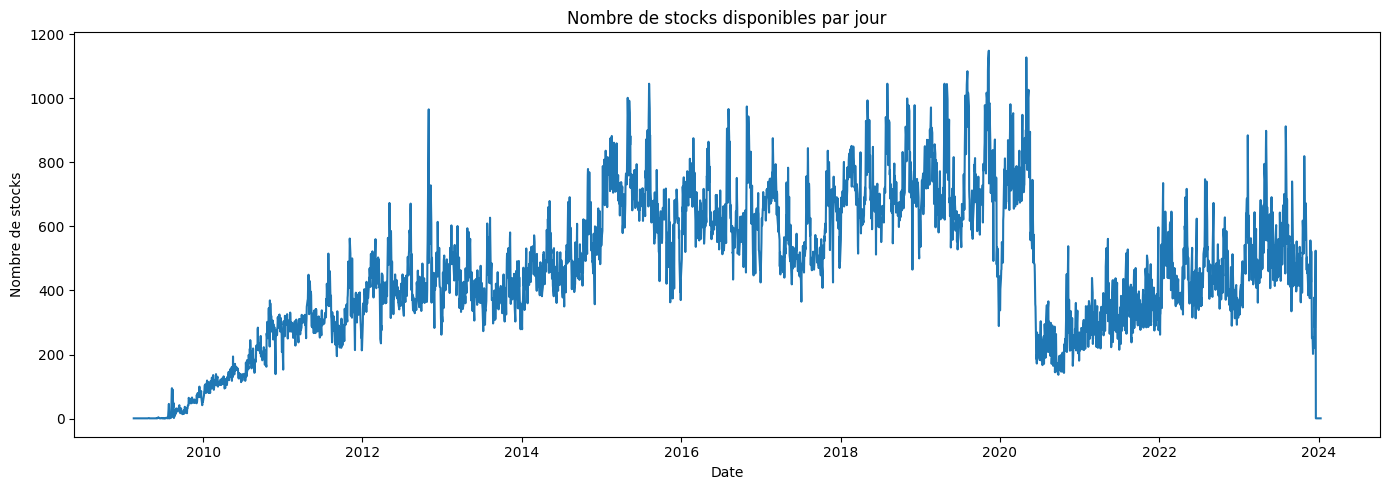

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(daily["effective_date"], daily["n_stocks"])
plt.xlabel("Date")
plt.ylabel("Nombre de stocks")
plt.title("Nombre de stocks disponibles par jour")
plt.tight_layout()
plt.show()

In [ ]:
daily["year"] = daily["effective_date"].dt.year

yearly_summary = (
    daily.groupby("year")["n_stocks"]
         .agg(["mean", "min", "max"])
         .reset_index()
)

yearly_summary

,year,mean,min,max
0,2009,30.581081,1,100
1,2010,173.769841,70,369
2,2011,318.027778,153,562
3,2012,428.400000,235,965
4,2013,422.329365,273,627
5,2014,499.825397,279,779
6,2015,684.257937,363,1045
7,2016,647.595238,425,974
8,2017,590.553785,365,875
9,2018,722.617530,465,1045


In [ ]:
threshold = daily["n_stocks"].quantile(0.05)
bad_days = daily[daily["n_stocks"] < threshold]
bad_days

,effective_date,n_stocks,year
0,2009-02-17,1,2009
1,2009-04-09,1,2009
2,2009-04-13,1,2009
3,2009-04-15,1,2009
4,2009-04-22,1,2009
5,2009-04-28,2,2009
6,2009-04-30,1,2009
7,2009-05-07,1,2009
8,2009-05-13,1,2009
9,2009-05-21,1,2009
